# Chromosome labeling

This notebook serves to illustrate an approach to segment chromosome positions based in 3D FISH data.

---

## 0. Environmental setup

In [1]:
from skimage import filters, segmentation, exposure, color, morphology, restoration, feature, measure
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import SimpleITK as sitk

# import the necessary packages
from __future__ import print_function
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import cv2

import sys

sys.path.append('..')

from src.utils.io import get_file_list

In [2]:
def show_plane(ax, plane, cmap="gray", title=None):
    ax.imshow(plane, cmap=cmap)
    ax.axis("off")

    if title:
        ax.set_title(title)

        
def explore_slices(data, cmap="gray"):
    from ipywidgets import interact
    N = len(data)

    @interact(plane=(0, N - 1))
    def display_slice(plane=34):
        fig, ax = plt.subplots(figsize=(20, 5))

        show_plane(ax, data[plane], title="Plane {}".format(plane), cmap=cmap)

        plt.show()

    return display_slice

def explore_slices_2_samples(data, cmap="gray"):
    from ipywidgets import interact
    N = len(data[0])

    @interact(plane=(0, N - 1))
    def display_slice(plane=34):
        fig, ax = plt.subplots(figsize=(20, 5), nrows=1, ncols=2)

        show_plane(ax[0], data[0][plane], title="Plane {}".format(plane), cmap=cmap)
        show_plane(ax[1], data[1][plane], title='Plane {}'.format(plane), cmap=cmap)

        plt.show()

    return display_slice


## Read in data

In [15]:
img = tifffile.imread('/home/daniel/PycharmProjects/nuclear_segmentation/data/tcell_project/raw_data/painted_tcell_fish_data/t_cell_chr4_chr17/activated/2.lsm')[0]
#img = tifffile.imread('/home/daniel/PycharmProjects/nuclear_segmentation/data/tcell_project/crops/20201023_131757/segmentations_all/1_s0_n0.tiff')

In [18]:
explore_slices(filters.median(img[:,0,:, :]), cmap='magma')

interactive(children=(IntSlider(value=34, description='plane', max=35), Output()), _dom_classes=('widget-inter…

<function __main__.explore_slices.<locals>.display_slice(plane=34)>

In [19]:
img_1 = img[:,0,:,:]
sliced = img_1.max(axis=0)

(512, 512)

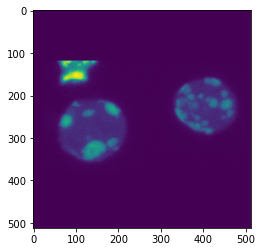

In [20]:
plt.imshow(sliced)
sliced.shape

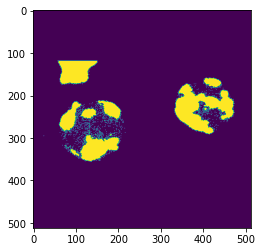

In [21]:
t = filters.threshold_otsu(img_1)
binary = sliced > t
binary = ndi.binary_fill_holes(binary)
plt.imshow(binary)

In [22]:
D = ndi.distance_transform_edt(binary)
markers = D > D.max() * 0.5
markers = ndi.label(markers)[0]
#localMax = feature.peak_local_max(D, indices=False, labels=binary)
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
#markers = ndi.label(localMax, structure=np.ones((3, 3)))[0]
labels = segmentation.watershed(-D, markers, mask=binary)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

[INFO] 8 unique segments found


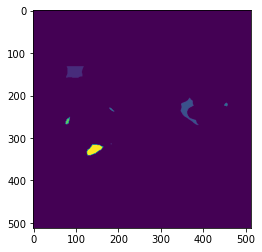

In [23]:
plt.imshow(markers)

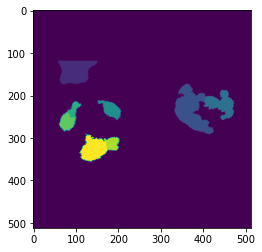

In [24]:
plt.imshow(labels)

In [25]:
im = sitk.GetImageFromArray(filters.gaussian(img_1, 2))

In [ ]:
h_filter = sitk.AdaptiveHistogramEqualization(im)

In [ ]:
f = sitk.GetArrayFromImage(h_filter)

In [ ]:
explore_slices(f)

In [ ]:
blurred = filters.median(img_1)

In [ ]:
explore_slices(blurred, cmap='magma')

In [ ]:
segmented = segmentation.morphological_chan_vese(blurred,1000)

In [ ]:
explore_slices(segmented)

In [ ]:
labeled = measure.label(segmented)
labeled.max()

In [ ]:
plt.imshow(labeled)

In [ ]:
def rescale_intensities(cell_imgs, qs=None, out_range=None):
    if qs is None:
        qs=[0.05, 99.5]
    if out_range is None:
        out_range = np.float32
    rescaled_cell_imgs = []
    
    for i in range(len(cell_imgs)):
        vmin, vmax = np.percentile(cell_imgs[i], q=qs)
        rescaled_cell_imgs.append(exposure.rescale_intensity(cell_imgs[i], in_range=(vmin, vmax), 
                                                             out_range=out_range))

    return rescaled_cell_imgs

In [ ]:
rescaled = rescale_intensities([blurred])[0]

In [ ]:
rescaled = exposure.adjust_gamma(sliced)

In [ ]:
t = rescaled.mean() + 3.25 *rescaled.std()
binary = rescaled > t

In [ ]:
explore_slices(binary)